In [1]:
from tf_chpvk_pv.dataset import *
import matplotlib.pyplot as plt
import pandas as pd

df = create_dataset()

train_df, test_df = train_test_split_()

2025-03-28 13:40:46.915 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV


2025-03-28 13:40:47.754 | INFO     | tf_chpvk_pv.dataset:create_dataset:39 - Processing dataset...
2025-03-28 13:40:48.846 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:164 - Processing dataset complete.
2025-03-28 13:40:49.096 | INFO     | tf_chpvk_pv.dataset:train_test_split_:178 - Creating train and test dataset...
2025-03-28 13:40:49.111 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:212 - Creating train and test dataset complete.


In [2]:
from tf_chpvk_pv.modeling.train import *

train_df, test_df, tolerance_factor_dict = evaluate_t_sisso('')

In [3]:
df = pd.concat([train_df, test_df])
df['type'] = 'Halogen'
df.loc[df.rX == 184.4, 'type'] = 'Chalcogen'
df.loc[df.rX == 198.14, 'type'] = 'Chalcogen'
df.loc[df['exp_label'] == 1, 'stab'] = 'Stable PVK'
df.loc[df['exp_label'] == 0, 'stab'] = 'Unstable PVK'

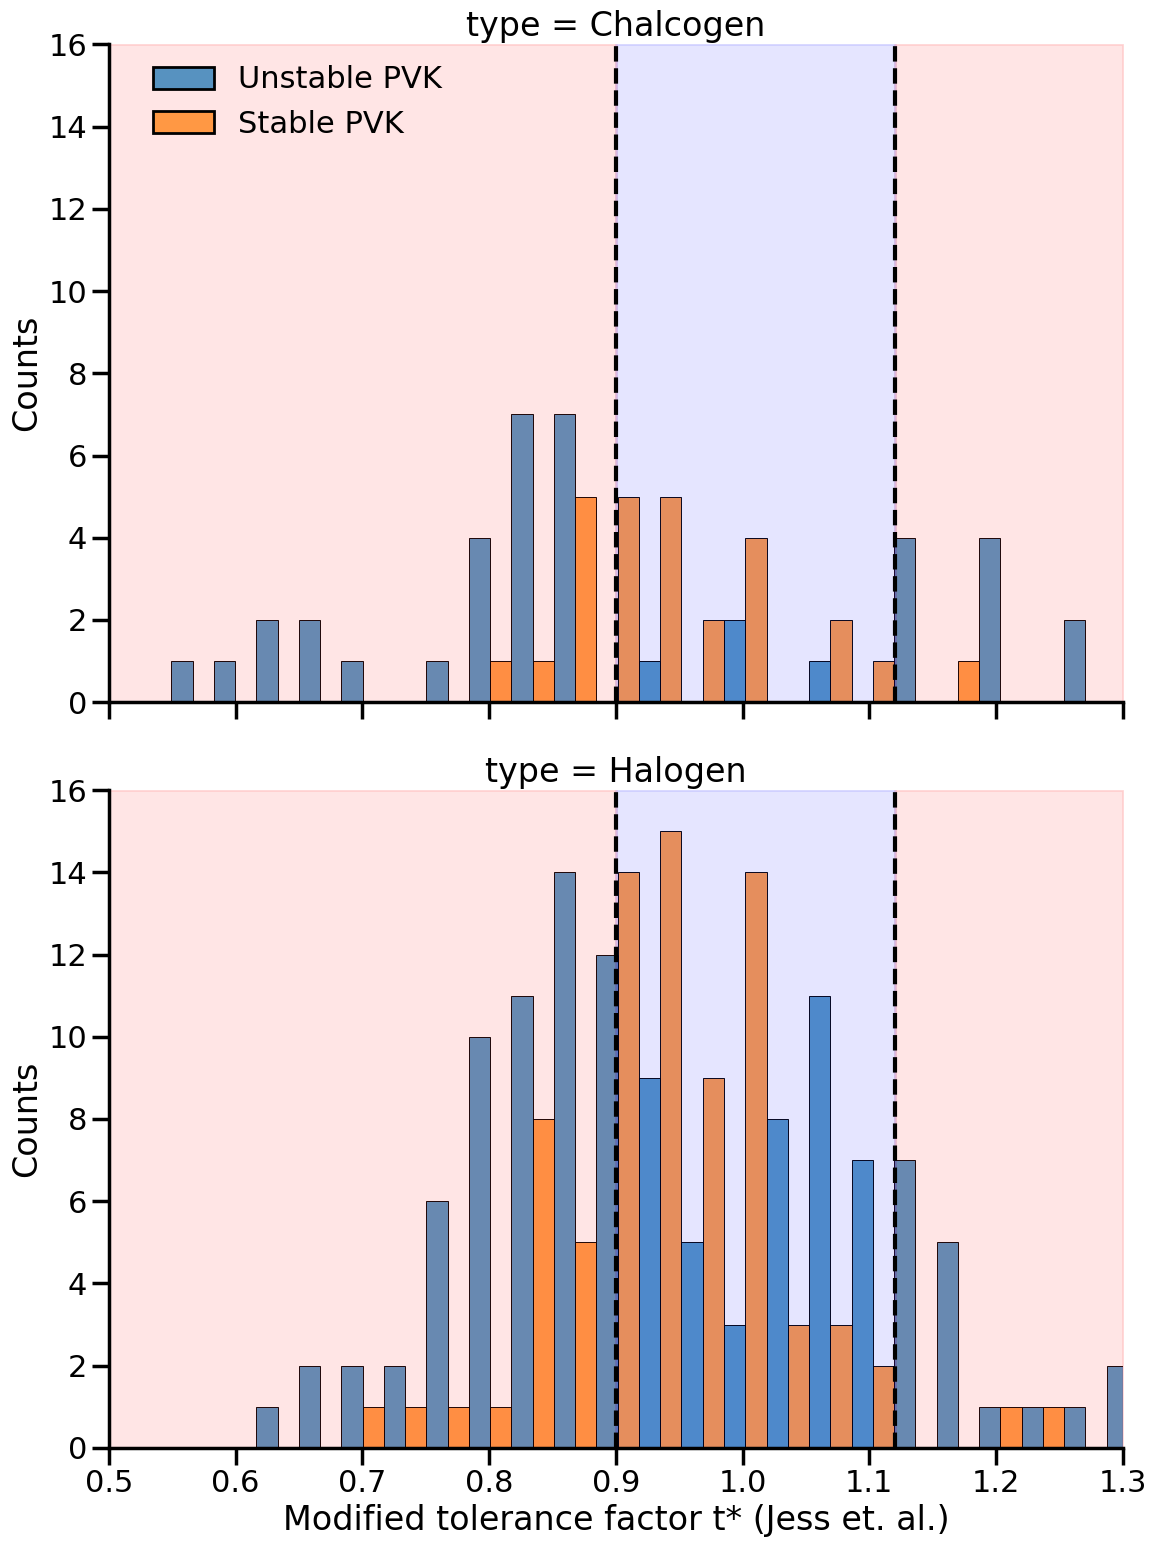

In [8]:
import seaborn as sns
from tf_chpvk_pv.config import FIGURES_DIR

sns.set_context("poster")
fg = sns.displot(data=df, x='t_jess', hue='stab',
                row='type', bins=50, 
                stat='count', height=8,
                multiple='dodge', aspect=1.5)



#sns.histplot(data=df, x='t_jess', hue=['exp_label', 'type'], bins=50, stat='percent', common_norm=False, multiple='dodge')
#sns.histplot(data=df[df['exp_label'] == 0], x='t_jess', hue='type', bins=50, stat='percent', common_norm=False, multiple='dodge')

xlims = [0.5, 1.3]
ylims = [0, 16]
th = [0.9, 1.12]

fg.refline(x=th[0], color='k', linestyle='--')
fg.refline(x=th[1], color='k', linestyle='--')

for ax in fg.axes:
    ax[0].fill_between([xlims[0],th[0]], ylims[0], ylims[1], color='red', alpha=0.1)
    ax[0].fill_between([th[0], th[1]], ylims[0], ylims[1], color='blue', alpha=0.1)
    ax[0].fill_between([th[1], xlims[1]], ylims[0], ylims[1], color='red', alpha=0.1)

plt.xlim(xlims)
plt.ylim(ylims)
sns.move_legend(fg, "upper left", title=None, frameon=False,
                bbox_to_anchor=(0.1, 0.96))

fg.set_axis_labels(x_var='Modified tolerance factor t* (Jess et. al.)', y_var='Counts')
fg.savefig(FIGURES_DIR / 'hist_dataset.png')

In [55]:
from tf_chpvk_pv.config import CRABNET_DIR
import pandas as pd

pvk_path = 'data/perovskite_bandgap_devices.csv'
pvkch_path = 'data/chalcogenides_bandgap_devices.csv'
ch_path = 'data/chalcogen_semicon_bandgap.csv'
path_data_grouped = 'data/df_grouped_formula_complete_dataset.csv'

df_pvk = pd.read_csv(CRABNET_DIR / pvk_path)
df_chalcogenides = pd.read_csv(CRABNET_DIR / pvkch_path)
df_chalc_semicon = pd.read_csv(CRABNET_DIR / ch_path)
for df_, sc in zip([df_pvk, df_chalcogenides, df_chalc_semicon], ['halide perovskite', 'chalcogenide perovskite', 'chalcogenide semiconductor']):
    df_['source'] = sc
df = pd.concat([df_pvk, df_chalcogenides, df_chalc_semicon])

df.rename(columns={'reduced_formulas':'formula'}, inplace=True)
df_grouped = pd.read_csv(CRABNET_DIR / path_data_grouped)


In [56]:
for formula in df_grouped['formula']:
    if df['formula'].str.contains(formula, regex=False).any():
        df_grouped.loc[df_grouped['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]
    else:
        print(formula)

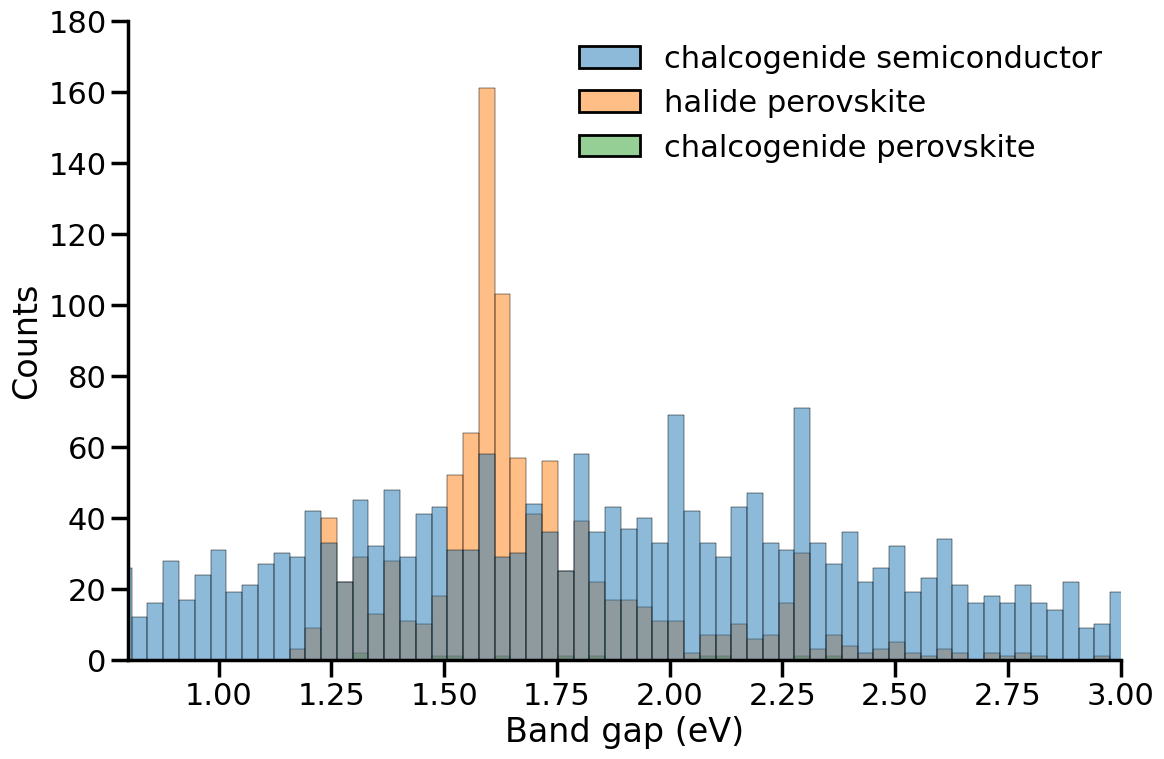

In [57]:
from tf_chpvk_pv.config import FIGURES_DIR
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("poster")

fg = sns.displot(data=df_grouped, x='target', hue='source', bins=200, 
                stat='count', height=8,
                #multiple='dodge',
                aspect=1.5)

sns.move_legend(fg, "upper left", title=None, frameon=False,
                bbox_to_anchor=(0.33, 0.96))

plt.xlim([0.8,3])
plt.ylim([0,180])
fg.set_axis_labels(x_var='Band gap (eV)', y_var='Counts')
fg.savefig(FIGURES_DIR / 'hist_dataset_Eg.png')